
--- Well-Conditioned Quadratic ---
Well-Conditioned Quadratic | SGD+Momentum converged in 1264 iterations.
Well-Conditioned Quadratic | Adam converged in 1311 iterations.
Well-Conditioned Quadratic | RMSProp converged in 40000 iterations.
Well-Conditioned Quadratic | CARMA converged in 267 iterations.


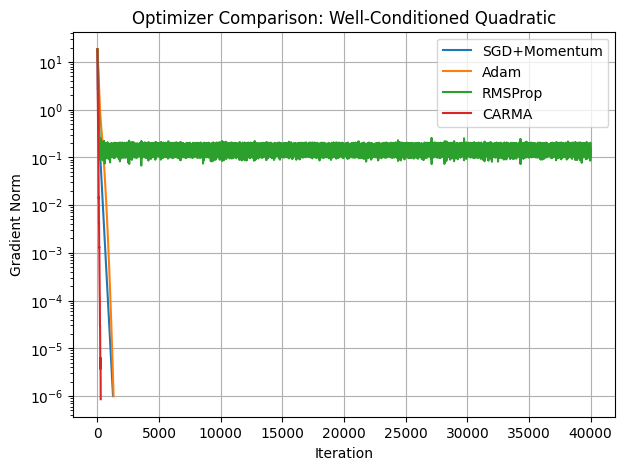


--- Ill-Conditioned Quadratic ---
Ill-Conditioned Quadratic | SGD+Momentum converged in 12578 iterations.
Ill-Conditioned Quadratic | Adam converged in 11477 iterations.
Ill-Conditioned Quadratic | RMSProp converged in 40000 iterations.
Ill-Conditioned Quadratic | CARMA converged in 527 iterations.


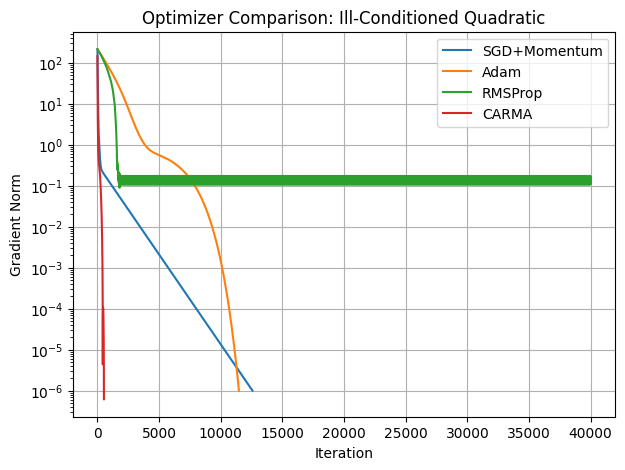


--- Rosenbrock Function ---
Rosenbrock Function | SGD+Momentum converged in 20437 iterations.
Rosenbrock Function | Adam converged in 11850 iterations.
Rosenbrock Function | RMSProp converged in 40000 iterations.
Rosenbrock Function | CARMA converged in 2003 iterations.


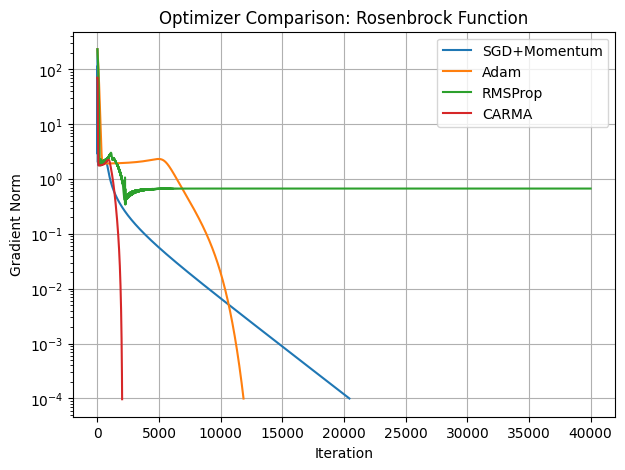

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -------------------------------
# Helper: Quadratic generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    V = np.linalg.qr(np.random.randn(dim, dim))[0]
    eigvals = np.linspace(1, cond_number, dim)
    Q = V @ np.diag(eigvals) @ V.T
    return Q

def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# -------------------------------
# Rosenbrock
# -------------------------------
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# ===========================================================
# ⭐ NEW OPTIMIZER: NAG Curvature + RMS Scaling ⭐
# ===========================================================
def nag_curv_rms(f, grad_f, x0,
                 lr=0.12, beta0=0.95, alpha_c=0.3,
                 beta_min=0.9, beta_max=0.99,
                 rho_s=0.99, eps=1e-8,
                 max_iter=5000, tol=1e-6,
                 grad_clip=50.0):

    x = x0.copy()
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    g_prev = np.zeros_like(x)
    losses = []

    for i in range(max_iter):

        # Nesterov lookahead
        y = x - lr * beta0 * v

        # Gradient
        g = grad_f(y)
        g = np.clip(g, -grad_clip, grad_clip)

        # Curvature estimation
        c = np.linalg.norm(g - g_prev) / (np.linalg.norm(g_prev) + eps)

        # Adaptive momentum
        beta_t = beta0 / (1 + alpha_c * c)
        beta_t = np.clip(beta_t, beta_min, beta_max)

        # RMS scaling
        s = rho_s * s + (1 - rho_s) * (g * g)

        # Momentum update
        v = beta_t * v + (1 - beta_t) * g

        # Parameter update
        x = x - lr * v / (np.sqrt(s) + eps)

        # Track loss as gradient norm
        losses.append(np.linalg.norm(g))

        # Save gradient
        g_prev = g.copy()

        if losses[-1] < tol:
            break

    return x, i+1, losses

# ===========================================================
# Baseline optimizers
# ===========================================================
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        g = grad_f(x)
        losses.append(np.linalg.norm(g))
        if np.linalg.norm(g) < tol: break
        v = beta * v + (1 - beta) * g
        x -= lr * v
    return x, i+1, losses

def adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8,
         tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []

    for t in range(1, max_iter+1):
        g = grad_f(x)
        losses.append(np.linalg.norm(g))
        if np.linalg.norm(g) < tol: break
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g*g)
        x -= lr * (m/(1-beta1**t)) / (np.sqrt(v/(1-beta2**t)) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.001, beta=0.9, eps=1e-8,
            tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []

    for i in range(max_iter):
        g = grad_f(x)
        losses.append(np.linalg.norm(g))
        if np.linalg.norm(g) < tol: break
        s = beta*s + (1-beta)*(g*g)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i+1, losses

# ===========================================================
# Plot runner
# ===========================================================
def run_and_plot(f, grad_f, x0, optimizers, tol, f_name, logy=True):
    plt.figure(figsize=(7,5))
    for name, opt in optimizers.items():
        x_opt, n_iter, losses = opt(f, grad_f, x0)
        print(f"{f_name} | {name} converged in {n_iter} iterations.")
        plt.plot(losses, label=name)

    if logy:
        plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(f"Optimizer Comparison: {f_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===============================================================
# 1) WELL-CONDITIONED QUADRATIC
# ===============================================================
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0 = np.random.randn(dim)

optimizers = {
    "SGD+Momentum": lambda f,g,x0=x0: sgd_momentum(f, g, x0, lr=0.01),
    "Adam": lambda f,g,x0=x0: adam(f, g, x0, lr=0.01),
    "RMSProp": lambda f,g,x0=x0: rmsprop(f, g, x0, lr=0.01),
    "CARMA": lambda f,g,x0=x0: nag_curv_rms(f, g, x0, lr=0.05),
}

print("\n--- Well-Conditioned Quadratic ---")
run_and_plot(lambda x: quadratic_f(x, Q_well),
             lambda x: quadratic_grad(x, Q_well),
             x0, optimizers, tol=1e-6,
             f_name="Well-Conditioned Quadratic")

# ===============================================================
# 2) ILL-CONDITIONED QUADRATIC
# ===============================================================
Q_ill = generate_quadratic(dim, cond_number=100)
x0 = np.random.randn(dim)

optimizers = {
    "SGD+Momentum": lambda f,g,x0=x0: sgd_momentum(f, g, x0, lr=0.001),
    "Adam": lambda f,g,x0=x0: adam(f, g, x0, lr=0.001),
    "RMSProp": lambda f,g,x0=x0: rmsprop(f, g, x0, lr=0.001),
    "CARMA": lambda f,g,x0=x0: nag_curv_rms(f, g, x0, lr=0.03),
}

print("\n--- Ill-Conditioned Quadratic ---")
run_and_plot(lambda x: quadratic_f(x, Q_ill),
             lambda x: quadratic_grad(x, Q_ill),
             x0, optimizers, tol=1e-6,
             f_name="Ill-Conditioned Quadratic")

# ===============================================================
# 3) ROSENBROCK
# ===============================================================
x0 = np.array([-1.2, 1.0])

optimizers = {
    "SGD+Momentum": lambda f,g,x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f,g,x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f,g,x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "CARMA": lambda f,g,x0=x0: nag_curv_rms(f, g, x0, lr=0.002, tol=1e-4),
}

print("\n--- Rosenbrock Function ---")
run_and_plot(rosenbrock_f, rosenbrock_grad,
             x0, optimizers, tol=1e-4,
             f_name="Rosenbrock Function")


MNIST Loaded.

=== Training with SGD+Momentum ===
Epoch 1: accuracy = 84.04%
Epoch 2: accuracy = 87.81%
Epoch 3: accuracy = 89.19%
Epoch 4: accuracy = 89.76%
Epoch 5: accuracy = 90.28%
Epoch 6: accuracy = 90.57%
Epoch 7: accuracy = 90.84%
Epoch 8: accuracy = 91.22%
Epoch 9: accuracy = 91.47%
Epoch 10: accuracy = 91.86%
Epoch 11: accuracy = 91.99%
Epoch 12: accuracy = 92.19%
Epoch 13: accuracy = 92.32%
Epoch 14: accuracy = 92.47%
Epoch 15: accuracy = 92.72%
Epoch 16: accuracy = 92.90%
Epoch 17: accuracy = 93.01%
Epoch 18: accuracy = 93.04%
Epoch 19: accuracy = 93.27%
Epoch 20: accuracy = 93.32%

=== Training with Adam ===
Epoch 1: accuracy = 94.05%
Epoch 2: accuracy = 95.62%
Epoch 3: accuracy = 96.49%
Epoch 4: accuracy = 97.02%
Epoch 5: accuracy = 97.47%
Epoch 6: accuracy = 97.49%
Epoch 7: accuracy = 97.53%
Epoch 8: accuracy = 97.55%
Epoch 9: accuracy = 97.57%
Epoch 10: accuracy = 97.80%
Epoch 11: accuracy = 97.68%
Epoch 12: accuracy = 97.61%
Epoch 13: accuracy = 97.85%
Epoch 14: accura

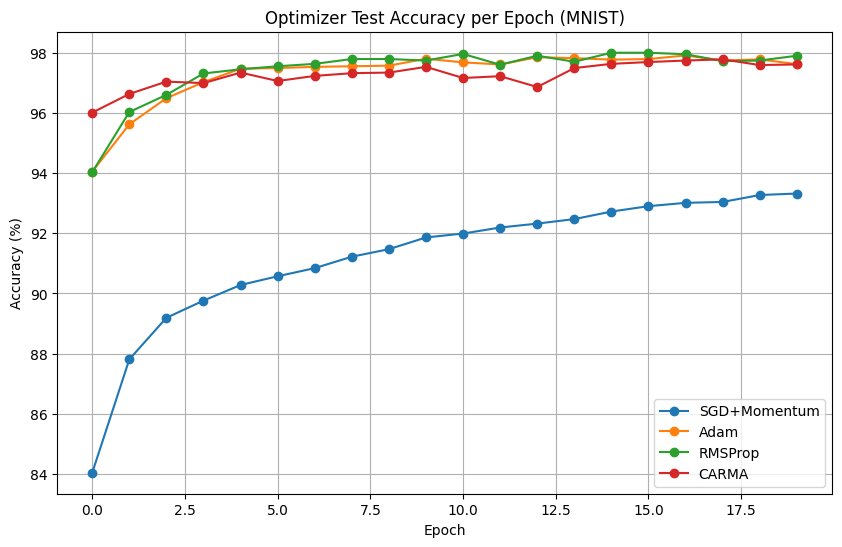

In [ ]:
import numpy as np
import gzip
import urllib.request
import time
import matplotlib.pyplot as plt

# ============================================================
# 1) FIXED MNIST LOADER (Google Mirror)
# ============================================================

def download(url, filename):
    urllib.request.urlretrieve(url, filename)

def load_mnist():
    base = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    files = {
        "train_images": (base + "train-images-idx3-ubyte.gz", "train-images.gz"),
        "train_labels": (base + "train-labels-idx1-ubyte.gz", "train-labels.gz"),
        "test_images":  (base + "t10k-images-idx3-ubyte.gz", "test-images.gz"),
        "test_labels":  (base + "t10k-labels-idx1-ubyte.gz", "test-labels.gz"),
    }

    for _, (url, filename) in files.items():
        download(url, filename)

    def load_images(filename):
        with gzip.open(filename, "rb") as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28*28).astype(np.float32) / 255.0

    def load_labels(filename):
        with gzip.open(filename, "rb") as f:
            return np.frombuffer(f.read(), np.uint8, offset=8)

    X_train = load_images("train-images.gz")
    y_train = load_labels("train-labels.gz")
    X_test  = load_images("test-images.gz")
    y_test  = load_labels("test-labels.gz")

    return X_train, y_train, X_test, y_test


print("Downloading MNIST...")
X_train, y_train, X_test, y_test = load_mnist()
print("MNIST Loaded.")

# ============================================================
# 2) Utility Functions
# ============================================================

def one_hot(y, num_classes=10):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

y_train_oh = one_hot(y_train)

def accuracy(params, X, y):
    out, _ = forward(params, X)
    preds = np.argmax(out, axis=1)
    return (preds == y).mean() * 100.0

# ============================================================
# 3) Simple Neural Network (1 Hidden Layer)
# ============================================================

def init_model(input_dim=784, hidden=128, output=10):
    W1 = np.random.randn(input_dim, hidden) / np.sqrt(input_dim)
    b1 = np.zeros(hidden)
    W2 = np.random.randn(hidden, output) / np.sqrt(hidden)
    b2 = np.zeros(output)
    return [W1, b1, W2, b2]

def forward(params, X):
    W1, b1, W2, b2 = params
    h = np.maximum(0, X @ W1 + b1)        # ReLU
    logits = h @ W2 + b2
    exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    out = exp / np.sum(exp, axis=1, keepdims=True)
    return out, h

def compute_gradients(params, X, y):
    W1, b1, W2, b2 = params
    m = X.shape[0]

    out, h = forward(params, X)
    dlogits = (out - y) / m

    dW2 = h.T @ dlogits
    db2 = np.sum(dlogits, axis=0)

    dh = dlogits @ W2.T
    dh[h <= 0] = 0

    dW1 = X.T @ dh
    db1 = np.sum(dh, axis=0)

    return [dW1, db1, dW2, db2]

# ============================================================
# 4) Optimizers
# ============================================================

def sgd_momentum_step(grads, state, hyper):
    v = state
    beta = hyper["beta"]
    lr = hyper["lr"]

    new_v = [beta*v_i + (1-beta)*g for v_i, g in zip(v, grads)]
    updates = [lr * v_i for v_i in new_v]
    return updates, new_v

def adam_step(grads, state, hyper):
    m, v, t = state
    lr = hyper["lr"]
    b1, b2 = hyper["beta1"], hyper["beta2"]
    eps = hyper["eps"]

    new_m = [b1*m_i + (1-b1)*g for m_i, g in zip(m, grads)]
    new_v = [b2*v_i + (1-b2)*(g*g) for v_i, g in zip(v, grads)]

    m_hat = [m_i/(1-b1**t) for m_i in new_m]
    v_hat = [v_i/(1-b2**t) for v_i in new_v]

    updates = [lr * m_i/(np.sqrt(v_i)+eps) for m_i, v_i in zip(m_hat, v_hat)]
    return updates, (new_m, new_v, t+1)

def rmsprop_step(grads, state, hyper):
    s = state
    beta = hyper["beta"]
    lr = hyper["lr"]
    eps = hyper["eps"]

    new_s = [beta*s_i + (1-beta)*(g*g) for s_i, g in zip(s, grads)]
    updates = [lr * g / (np.sqrt(s_i) + eps) for g, s_i in zip(grads, new_s)]
    return updates, new_s

def nag_curv_rms_step(grads, state, hyper):
    v, s, g_prev = state

    lr = hyper["lr"]
    beta0 = hyper["beta0"]
    alpha_c = hyper["alpha_c"]
    beta_min, beta_max = hyper["beta_min"], hyper["beta_max"]
    rho_s = hyper["rho_s"]
    eps = hyper["eps"]

    g_flat = np.concatenate([g.ravel() for g in grads])
    gp_flat = np.concatenate([g.ravel() for g in g_prev])
    c = np.linalg.norm(g_flat - gp_flat) / (np.linalg.norm(gp_flat) + eps)
    beta_t = np.clip(beta0 / (1 + alpha_c * c), beta_min, beta_max)

    new_v = [beta_t*v_i + (1-beta_t)*g for v_i, g in zip(v, grads)]
    new_s = [rho_s*s_i + (1-rho_s)*(g*g) for s_i, g in zip(s, grads)]

    updates = [lr * v_i / (np.sqrt(s_i)+eps) for v_i, s_i in zip(new_v, new_s)]
    return updates, (new_v, new_s, grads)

# ============================================================
# 5) Training Loop (MODIFIED TO RECORD ACCURACY)
# ============================================================

def train_optimizer(name, step_fn, hyper, epochs=20, batch=128):
    params = init_model()
    N = X_train.shape[0]
    acc_history = []      # NEW

    # Initial optimizer state
    if name == "SGD+Momentum":
        state = [np.zeros_like(p) for p in params]
    elif name == "Adam":
        state = ([np.zeros_like(p) for p in params],
                 [np.zeros_like(p) for p in params], 1)
    elif name == "RMSProp":
        state = [np.zeros_like(p) for p in params]
    elif name == "CARMA":
        state = (
            [np.zeros_like(p) for p in params],
            [np.zeros_like(p) for p in params],
            [np.zeros_like(p) for p in params]
        )

    print(f"\n=== Training with {name} ===")

    for ep in range(epochs):
        idx = np.random.permutation(N)
        Xb = X_train[idx]
        Yb = y_train_oh[idx]

        for i in range(0, N, batch):
            X_batch = Xb[i:i+batch]
            Y_batch = Yb[i:i+batch]

            grads = compute_gradients(params, X_batch, Y_batch)
            updates, state = step_fn(grads, state, hyper)

            for p, u in zip(params, updates):
                p -= u

        acc = accuracy(params, X_test, y_test)
        acc_history.append(acc)
        print(f"Epoch {ep+1}: accuracy = {acc:.2f}%")

    return params, acc_history


# ============================================================
# 6) Run Optimizers + Collect Accuracy Curves
# ============================================================

acc_histories = {}

_, acc_histories["SGD+Momentum"] = train_optimizer(
    "SGD+Momentum",
    sgd_momentum_step,
    {"lr":0.01, "beta":0.9}
)

_, acc_histories["Adam"] = train_optimizer(
    "Adam",
    adam_step,
    {"lr":0.001, "beta1":0.9, "beta2":0.999, "eps":1e-8}
)

_, acc_histories["RMSProp"] = train_optimizer(
    "RMSProp",
    rmsprop_step,
    {"lr":0.001, "beta":0.9, "eps":1e-8}
)

_, acc_histories["CARMA"] = train_optimizer(
    "CARMA",
    nag_curv_rms_step,
    {
        "lr":0.01, "beta0":0.95, "alpha_c":0.3,
        "beta_min":0.9, "beta_max":0.99,
        "rho_s":0.99, "eps":1e-8
    }
)

# ============================================================
# 7) ACCURACY GRAPH
# ============================================================

plt.figure(figsize=(10,6))
for name, acc in acc_histories.items():
    plt.plot(acc, label=name, marker='o')

plt.title("Optimizer Test Accuracy per Epoch (MNIST)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
